# Automated analysis of EEG signal quality using the data from the Dreem Headband by Beacon Biosignals

**Rapport réalisé par Anatole Belloni et Raphaël Faure**

Challenge Kaggle : **EEG signal quality analysis by Beacon Biosignals**

Nom d'équipe : **ABELLONI_RFAURE**


In [1]:
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import pandas as pd
from scipy.signal import butter, filtfilt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, Subset

# Premières solutions et limites

Nous avons tout d'abord repris le traitement proposé dans le notebook du projet en cherchant des features pertinentes pour notre modèle. Nous avons alors testé des modèles comme Random Forest ou XGB mais ayant à chaque fois de nouvelles idées de features, nous nous sommes rapidement demandé s'il n'existait pas un moyen pour extraire directement un nombre fixe de features pertinentes. Nous nous sommes ainsi naturellement tourné vers des méthodes de Deep Learning. Nous avons alors testé plusieurs modèles et dimensionement, et c'est le CNN qui a obtenu les meilleurs résultats.

# Plan de la solution actuelle
La solution qu'on a imaginé est donc un Convolutionnal Neural Network (CNN) combiné avec un XGBoost. La suite du code suivra alors le plan suivant :
- Création des classes de datasets et du modèle
- Limite de la loss usuelle et création d'une nouvelle
- Résultats


## Classes des objets

### Dataset train et test

La question du prétraitement des données est essentielle, surtout dans des tâches comme la classification de signaux EEG, où le bruit est présent sous différentes formes : biais du capteur (fréquence basse), bruit gaussien (fréquence haute). Pour cela, nous avons reutilisé les passes-bandes donnés dans le notebook d'introduction.

In [2]:
# Bandpass

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs  # Fréquence de Nyquist
    normal_cutoff = cutoff / nyquist  # Fréquence de coupure normalisée
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)


Pour faciliter notre travail par la suite, nous allons créer une classe EEGtrainset qui nous permettera de charger les données et de les mettre en forme.

In [4]:
def reshape_array_into_windows(x, sample_rate, window_duration_in_seconds):
    """
    Reshape the data into an array of shape (C, T, window) where 'window' contains
    the points corresponding to 'window_duration' seconds of data.

    Parameters:
    x (numpy array): The input data array.
    sample_rate (int): The number of samples per second.
    window_duration_in_seconds (float): The duration of each window in seconds.

    Returns:
    reshaped_x (numpy array): The reshaped array with shape (C, T, window).
    """
    # Calculate the number of samples in one window
    window_size = int(window_duration_in_seconds * sample_rate)

    # Ensure the total length of x is a multiple of window_size
    total_samples = x.shape[-1]
    if total_samples % window_size != 0:
        # Truncate or pad x to make it divisible by window_size
        x = x[..., :total_samples - (total_samples % window_size)]
    # Reshape x into (C, T, window)
    reshaped_x = x.reshape(x.shape[0], -1, window_size)

    return reshaped_x


In [5]:
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset

class EEGDataset_train(Dataset):
    def __init__(self, signal_files, target_files, sample_rate=250, window_duration=2):
        """
        Initialise le dataset EEG.

        Parameters:
        signal_files (list): Liste des chemins des fichiers de signaux EEG.
        target_files (list): Liste des chemins des fichiers de labels correspondants.
        sample_rate (int): Fréquence d'échantillonnage des signaux.
        window_duration (int): Durée de chaque fenêtre (en secondes).
        """
        self.data = []
        self.targets = []
        self.sample_rate = sample_rate
        self.window_duration = window_duration
        data = [(np.load(signal_files[i]),np.load(target_files[i])) for i in range(len(signal_files))]
        for i,(signal,target) in enumerate(data):
            print()
            print(f"Recording {i}")
            print("Data shape", signal.shape,target.shape)
            print("Data duration:", signal.shape[1]/250)
            print("Labels duration",target.shape[1] * 2)
        for (signals,targets) in data:
            # Découper les signaux en fenêtres
            filtered_signals = butter_bandpass_filter(signals,0.1,100,250,4)
            reshaped_signals = reshape_array_into_windows(filtered_signals, sample_rate, window_duration)  # (C, T, window_size)
            reshaped_signals = reshaped_signals.reshape((-1,reshaped_signals.shape[-1]))
            self.data.append(reshaped_signals)

            # Truncate les labels pour s'aligner avec les fenêtres
            targets_flatten = targets.reshape((-1))
            self.targets.append(targets_flatten)

        # Convertir en arrays numpy
        self.data = np.concatenate(self.data, axis=0)  # (Total_T, window_size)
        self.targets = np.concatenate(self.targets, axis=0)  # (Total_T,)
        assert self.data.shape[0] == self.targets.shape[0]

    def __len__(self):
        # Retourne le nombre total de fenêtres (tous canaux confondus)
        return self.data.shape[0]

    def __getitem__(self, idx):
        # Retourne une fenêtre EEG et son label correspondant
        signal = self.data[idx, :]  # (window_size,)
        label = self.targets[idx]  # (1,)
        return signal, label

    def train_test_split(self, tau=0.8, random_seed=None):
        """
        Sépare le dataset en un train_set et un test_set en fonction de la proportion tau.

        Parameters:
        tau (float): Proportion des données dans le train_set (entre 0 et 1).
        random_seed (int, optional): Seed pour le mélange aléatoire des indices.

        Returns:
        train_set (Subset): Sous-ensemble d'entraînement.
        test_set (Subset): Sous-ensemble de test.
        """
        # Nombre total d'échantillons
        total_samples = len(self)

        # Mélanger les indices
        indices = np.arange(total_samples)
        if random_seed is not None:
            np.random.seed(random_seed)
        np.random.shuffle(indices)

        # Calculer la taille des ensembles
        train_size = int(total_samples * tau)
        train_indices = indices[:train_size]
        test_indices = indices[train_size:]

        # Créer des Subsets pour train et test
        train_set = Subset(self, train_indices)
        test_set = Subset(self, test_indices)

        return train_set, test_set


In [6]:
import numpy as np
from torch.utils.data import Dataset

class EEGDataset_test(Dataset):
    def __init__(self, signal_files, sample_rate=250, window_duration=2):
        """
        Initialise le dataset EEG pour les données de test.

        Parameters:
        - signal_files (list): Liste des chemins des fichiers de signaux EEG.
        - sample_rate (int): Fréquence d'échantillonnage des signaux.
        - window_duration (int): Durée de chaque fenêtre (en secondes).
        """
        self.data = []
        self.sample_rate = sample_rate
        self.window_duration = window_duration

        for signal_file in signal_files:
            # Charger les signaux
            signals = np.load(signal_file)  # (C, N_samples)
            print(f"Loaded signal shape: {signals.shape}")  # Debug

            # Découper les signaux en fenêtres
            filtered_signals = butter_bandpass_filter(signals,0.1,100,250,4)
            reshaped_signals = reshape_array_into_windows(filtered_signals, sample_rate, window_duration)  # (C, T, window_size)
            print(f"Reshaped signal shape: {reshaped_signals.shape}")  # Debug
            reshaped_signals = reshaped_signals.reshape((-1,reshaped_signals.shape[-1]))
            # Ajouter les signaux reshaped à la liste globale
            self.data.append(reshaped_signals)

        # Combiner toutes les données
        self.data = np.concatenate(self.data, axis=0)  # (C, Total_T, window_size)
        print(f"Final concatenated data shape: {self.data.shape}")  # Debug

    def __len__(self):
        """
        Retourne le nombre total de fenêtres (Total_T).
        """
        return self.data.shape[0]

    def __getitem__(self, idx):
        """
        Retourne une fenêtre (signal) et un label factice.

        Parameters:
        - idx (int): Index de la fenêtre.

        Returns:
        - signal (numpy array): Fenêtre EEG de forme (C, window_size).
        - dummy_label (int): Faux label (-1).
        """
        signal = self.data[ idx, :]  # (C, window_size)
        dummy_label = -1  # Pas de label pour le test
        return signal, dummy_label


L'intérêt des classes est de personnaliser le pipeline de données en fonction des besoins spécifiques, tout en intégrant efficacement les prétraitements, la gestion des labels et la compatibilité avec les DataLoaders. 

### CNN

- Les **Convolutional Neural Networks (CNN)** sont conçus pour extraire des motifs cachés, même dans des données bruitées, grâce à leurs filtres convolutifs qui apprennent automatiquement les caractéristiques pertinentes. Les CNN sont donc particulièrement adaptés à cette tâche, car ils vont pouvoir:
  - capturer les motifs significatifs dans le signal, indépendamment du bruit.
  - exploiter les informations dans plusieurs bandes de fréquence sans nécessiter de prétraitements complexes.

- A propos des traitements, dans le cas des signaux EEG, une analyse empirique a montré que la bande de fréquence [0.1  $\text{Hz}$, 100  $\text{Hz}$] donne les meilleurs résultats :
  - Les basses fréquences < 0.1 $\text{Hz}$ capturent essentiellement des termes continus dus aux capteurs.
  - Les hautes fréquences > 100 $\text{Hz}$ contiennent principalement du bruit. Une bande plus large (\(> 100 $\text{Hz}$\)) n’améliorait donc pas les résultats. Ce choix de bande de fréquence représente le meilleur compromis pour inclure suffisamment d’informations pertinentes tout en excluant les données bruitées.

In [7]:
import torch
import torch.nn as nn

class TemporalCNN(nn.Module):
    def __init__(self, nb_points_entree=500, nb_class=2, dropout_rate=0.2,
                 filters=[16, 32, 64], kernel_sizes=[64, 32, 16]):
        """
        Paramètres modifiables :
        - filters (list): Nombre de filtres pour chaque couche convolutionnelle.
        - kernel_sizes (list): Taille des noyaux pour chaque couche convolutionnelle.
        """
        super(TemporalCNN, self).__init__()

        self.conv1 = nn.Conv1d(1, filters[0], kernel_size=kernel_sizes[0], stride=1, padding=kernel_sizes[0] // 2)
        self.batch_norm1 = nn.BatchNorm1d(filters[0])

        self.conv2 = nn.Conv1d(filters[0], filters[1], kernel_size=kernel_sizes[1], stride=1, padding=kernel_sizes[1] // 2)
        self.batch_norm2 = nn.BatchNorm1d(filters[1])

        self.conv3 = nn.Conv1d(filters[1], filters[2], kernel_size=kernel_sizes[2], stride=1, padding=kernel_sizes[2] // 2)
        self.batch_norm3 = nn.BatchNorm1d(filters[2])

        self.pool = nn.AvgPool1d(kernel_size=4)
        self.dropout = nn.Dropout(dropout_rate)

        # Calcul de la taille d'entrée pour la couche fully connected
        fc_input_size = filters[2] * (nb_points_entree // 4)
        self.fc = nn.Linear(fc_input_size, nb_class)

    def forward(self, x):
        # Ajouter une dimension pour les canaux (batch_size, 1, window_size)
        x = x.unsqueeze(1)

        # Pipeline convolutif
        x = torch.relu(self.batch_norm1(self.conv1(x)))
        x = torch.relu(self.batch_norm2(self.conv2(x)))
        x = torch.relu(self.batch_norm3(self.conv3(x)))
        x = self.pool(x)

        # Aplatir et passer dans les couches fully connected
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return torch.log_softmax(x, dim=1)


### Fonctions Loss

- **Limites de la Binary Cross-Entropy (BCE) :**
  - Dans ce projet, les données sont déséquilibrées avec ~60% de 1 et ~40% de 0 (cf. le tenseur class_weights), ce qui rend la BCE inadaptée, car elle ne pénalise pas suffisamment les erreurs sur la classe minoritaire.  L'ajout de poids de classe pour compenser cet effet a montré des résultats limités pour résoudre le problème de déséquilibre. La vitesse de convergence était vraiment plus faible.

- **Focus sur le Kappa Score :**
  - Le **Kappa score** est une mesure utilisée pour évaluer la concordance entre deux ensembles de classifications, tout en tenant compte de la concordance qui pourrait se produire par hasard. C'est de plus une métrique qui nous intéresse particulièrement étant donné que c'est celle qu'on cherche à maximiser pour ce challenge. L'idée est donc d'ajouter un terme valorisant le kappa score de la binary cross entropie. Cependant, sa non-différentiabilité empêche son utilisation directe comme fonction de perte pour optimiser le modèle. Aucune implémentation native de la **Kappa Loss** n'existe de plus dans PyTorch, ce qui a nécessité le développement d'une approximation différentiable spécifique pour ce projet. Combiner la **Kappa Loss** avec d'autres métriques comme la précision peut introduire des difficultés supplémentaires dans l'entraînement, avec une convergence plus lente et une sensibilité accrue aux hyperparamètres, tels que l'alpha dans la combinaison des pertes. (cf. le prochain markdown)


#### Formalisation de l'approximation de $\kappa$
##### 1. Matrice d'accords observés

La matrice des accords observés $\mathbf{O}$ est donnée par :

$$
\mathbf{O} =
\begin{bmatrix}
O_{00} & O_{01} \\
O_{10} & O_{11}
\end{bmatrix}
$$

où chaque élément $O_{ij}$ est calculé comme suit :

$$
O_{ij} = \frac{\sum_{k} \mathbb{1}[y_{\text{true},k} = i] \cdot p_{\text{pred},k}(j)}{\sum_{k} \mathbb{1}[y_{\text{true},k} = i]}
$$

avec :
- $i, j \in \{0, 1\}$,
- $p_{\text{pred},k}(j)$ est la probabilité prédite pour la classe $j$,
- $\mathbb{1}[y_{\text{true},k} = i]$ est une fonction indicatrice valant $1$ si $y_{\text{true},k} = i$, sinon $0$.

Pour normaliser, on peut écrire sous forme matricielle:

$$
\mathbf{O} = \frac{\mathbf{T}^\top \mathbf{P}}{\sum \mathbf{T}^\top \mathbf{P}}
$$

où :
- $\mathbf{T}$ est le vecteur des labels réels ($2 \times n$, one-hot encodé),
- $\mathbf{P}$ est le vecteur des probabilités prédites ($2 \times n$).

---

##### 2. Matrice d'accords attendus

La matrice attendue $\mathbf{E}$, qui représente les accords obtenus par hasard, est donnée par :

$$
\mathbf{E} =
\begin{bmatrix}
E_{00} & E_{01} \\
E_{10} & E_{11}
\end{bmatrix}
$$

Chaque élément est calculé comme suit :

$$
E_{ij} = \frac{r_i \cdot c_j}{\left( \sum \mathbf{O} \right)^2}
$$

avec :
- $r_i = \sum_{j} O_{ij}$, la somme des accords observés pour la classe réelle $i$,
- $c_j = \sum_{i} O_{ij}$, la somme des accords observés pour la classe prédite $j$,
- $\sum \mathbf{O} = \sum_{i,j} O_{ij}$, le total des échantillons.

---

##### Interprétation

- $\mathbf{E}$ suppose que les accords entre labels réels et prédictions sont **indépendants**.
- Les diagonales ($E_{00}, E_{11}$) représentent les accords attendus pour les classes 0 et 1, respectivement, si les prédictions étaient aléatoires.
- Les hors-diagonales $(E_{01}, E_{10})$ représentent les erreurs attendues par hasard.

---

##### 3. Approximation du Kappa Score

Le Kappa Score est défini comme une mesure normalisée comparant les accords observés $\mathbf{O}$ et les accords attendus $\mathbf{E}$ :

$$
\kappa = \frac{\text{trace}(\mathbf{O}) - \text{trace}(\mathbf{E})}{1 - \text{trace}(\mathbf{E}) + \epsilon}
$$

Dans le cas binaire, cela devient :

$$
\kappa = \frac{O_{00} + O_{11} - (E_{00} + E_{11})}{1 - (E_{00} + E_{11}) + \epsilon}
$$

avec :
- $\text{trace}(\mathbf{O}) = O_{00} + O_{11}$, représentant les accords exacts entre classes,
- $\text{trace}(\mathbf{E}) = E_{00} + E_{11}$, représentant les accords attendus entre classes.

---

##### Cas particuliers pour le Kappa Score

1. **Prédictions parfaites :**
   Si le modèle prédit correctement toutes les classes :

   $$
   \text{trace}(\mathbf{O}) = 1 \quad \text{et} \quad \text{trace}(\mathbf{E}) \approx 0 \implies \kappa \approx 1
   $$

   Cela signifie que le modèle est parfaitement en accord avec les labels réels.

2. **Prédictions aléatoires :**
   Si les prédictions sont indépendantes des labels réels :

   $$
   \text{trace}(\mathbf{O}) \approx \text{trace}(\mathbf{E}) \implies \kappa \approx 0
   $$

   Cela indique que le modèle ne fait pas mieux qu'un tirage aléatoire.

3. **Prédictions pires que le hasard :**
   Si le modèle prédit systématiquement de manière opposée aux labels réels :

   $$
   \text{trace}(\mathbf{O}) < \text{trace}(\mathbf{E}) \implies \kappa < 0
   $$

   Cela reflète un modèle contre-productif.

---

##### 4. Combinaison avec la Cross Entropy Loss

La fonction de perte combinée utilise le Kappa Score et l'entropie croisée :

$$
\mathcal{L}_{\text{combined}} = \alpha \cdot \mathcal{L}_{CE} + (1 - \alpha) \cdot (1 - \kappa)
$$

où :
- $\mathcal{L}_{CE}$ est la **Binary Cross Entropy Loss** donnée par :
  $$
  \mathcal{L}_{CE} = -\frac{1}{n} \sum_{k=1}^{n} \left[ y_k \log(p_k) + (1 - y_k) \log(1 - p_k) \right]
  $$
- $(1 - \kappa)$ est une pénalité basée sur le Kappa Score, qui diminue à mesure que $\kappa$ augmente.

---


In [10]:
class CombinedKappaCrossEntropyLoss(nn.Module):
    def __init__(self, num_classes=2, alpha=0.2, class_weights=None, epsilon=1e-7):
        """
        Combinaison de CrossEntropyLoss et Kappa Loss.

        Parameters:
        - num_classes (int): Nombre de classes.
        - alpha (float): Pondération entre CrossEntropy et Kappa Loss.
        - class_weights (torch.Tensor, optional): Poids des classes.
        - epsilon (float): Constante pour éviter les divisions par zéro.
        """
        super(CombinedKappaCrossEntropyLoss, self).__init__()
        self.alpha = alpha
        self.num_classes = num_classes
        self.epsilon = epsilon
        self.class_weights = class_weights

    def forward(self, logits, targets):
        # Déplacer les poids des classes sur le bon appareil
        device = logits.device
        if self.class_weights is not None:
            class_weights = self.class_weights.to(device)
        else:
            class_weights = torch.ones(self.num_classes).to(device)

        # CrossEntropy Loss
        cross_entropy = nn.CrossEntropyLoss(weight=class_weights)
        ce_loss = cross_entropy(logits, targets)

        # Kappa Loss
        probs = torch.softmax(logits, dim=1)
        targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=self.num_classes).float().to(device)

        observed = torch.matmul(targets_one_hot.T, probs)  # Matrice de confusion probabiliste
        weighted_observed = observed
        row_sum = weighted_observed.sum(dim=1, keepdim=True)
        col_sum = weighted_observed.sum(dim=0, keepdim=True)
        total = weighted_observed.sum()

        expected = torch.matmul(row_sum, col_sum) / total
        observed = weighted_observed / total
        expected = expected / total

        kappa = (observed.trace() - expected.trace()) / (1 - expected.trace() + self.epsilon)
        kappa_loss = 1 - kappa

        # Combinaison des deux pertes
        combined_loss =  self.alpha*ce_loss + (1-self.alpha )* kappa_loss
        return combined_loss



## Résultats et optimisations

### Chargement des données

Le seed est fixé à 42 et les batchs de taille 64 se sont avérés être les plus adaptés au problème

In [11]:
signal_files = [r"train\data_0.npy", r"train\data_1.npy", r"train\data_2.npy",r"train\data_3.npy"]  # Exemple de fichiers
target_files = [r"train\target_0.npy", r"train\target_1.npy",r"train\target_2.npy", r"train\target_3.npy"]
dataset = EEGDataset_train(signal_files, target_files)


Recording 0
Data shape (5, 7712740) (5, 15425)
Data duration: 30850.96
Labels duration 30850

Recording 1
Data shape (5, 5232364) (5, 10464)
Data duration: 20929.456
Labels duration 20928

Recording 2
Data shape (5, 6421756) (5, 12843)
Data duration: 25687.024
Labels duration 25686

Recording 3
Data shape (5, 6809761) (5, 13619)
Data duration: 27239.044
Labels duration 27238


In [88]:
# Diviser en train/test
train_set, test_set = dataset.train_test_split(tau=0.8, random_seed=42)
# Charger les données
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)
# Initialiser le modèle
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
from sklearn.utils.class_weight import compute_class_weight

# Calculer les poids pour les classes
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=dataset.targets)  # y_train : labels d'entraînement
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [36]:
class_weights

tensor([1.2430, 0.8365], device='cuda:0')

On note le désquilibre des classes mentionné précédemment.

### Modèle

In [ ]:
# Initialiser le modèle avec les hyperparamètres proposés
model_cnn = TemporalCNN()
model_ = model_cnn
class_weights = torch.tensor(class_weights).to(device)
model_.to(device)
criterion = CombinedKappaCrossEntropyLoss(alpha=0.2,class_weights=class_weights)
optimizer = optim.Adam(model_.parameters(), lr=0.001)
m=40
model_.train()
step_loss = []
for epoch in range(m):
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        x_batch = x_batch.float()
        outputs = model_(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    step_loss.append(train_loss)
    print(f"Epoch {epoch+1}/{m}, Loss: {train_loss/len(train_loader):.4f}")

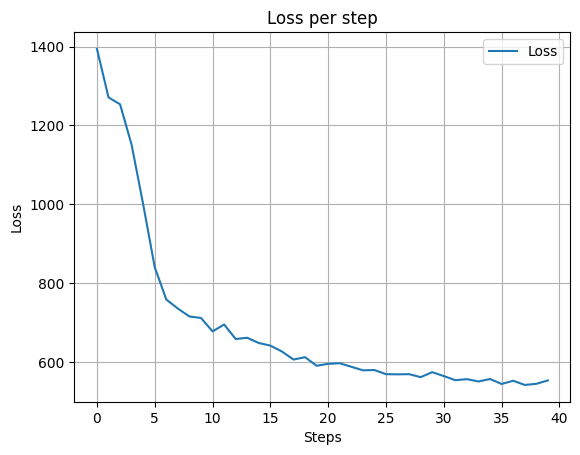

In [ ]:
plt.plot([k for k in range(m)], step_loss, label='Loss')  
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend() 
plt.grid()
plt.title('Loss per step')
plt.show()

On obtient une courbe d'apprentissage satisfaisante avec une convergence en 25-30 steps.

### Evaluation 

In [92]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def eval_trainset(model=model_):

    # Évaluation des métriques
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            x_batch = x_batch.float()
            outputs = model(x_batch)
            _, preds = torch.max(outputs, 1)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    # Calcul des métriques
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    print(f"Accuracy: {accuracy:}")
    print(f"Precision: {precision:}")
    print(f"Recall: {recall:}")
    print(f"F1 Score: {f1:}")
    print(f"Kappa Score: {kappa:}")

def eval_testset(model=model_):
    # Évaluation des performances (accuracy ici)
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            x_batch = x_batch.float()
            outputs = model(x_batch)
            _, predicted = torch.max(outputs, 1)
            #predicted = (predicted >= 0.001).long()
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Kappa Score: {kappa:.4f}")

In [131]:
print('Resultats train set')
eval_trainset()
print('Resultats test set')
eval_testset()

Resultats train set
Accuracy: 0.8673091249450823
Precision: 0.8249202727406162
Recall: 0.9876665495095377
F1 Score: 0.8989871816311247
Kappa Score: 0.7101437049886167
Resultats test set
Accuracy: 0.8669
Precision: 0.8244
Recall: 0.9876
F1 Score: 0.8986
Kappa Score: 0.7094


### Ajout du XGB

Même si nous avons un CNN assez performant, nous n'arrivions pas néanmoins à améliorer ses résultats. Pour ça nous avons ajouté un XGB en sortie de la dernière couche du modèle (avant le pooling). L'idée est de donner les features obtenues par le CNN au XGB afin qu'il s'entraîne à son tour dessus.

In [133]:
# 2. Extraire les caractéristiques du CNN
model_.eval()
features_train = []
labels_train = []

with torch.no_grad():
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        
        # Sortie des caractéristiques du CNN
        features_cnn = model_(x_batch.float()).cpu().numpy()
        
        # Ajouter les caractéristiques du CNN directement
        features_train.append(features_cnn)
        labels_train.append(y_batch.cpu().numpy())

# Rassembler les caractéristiques et les labels
features_train = np.vstack(features_train)
labels_train = np.hstack(labels_train)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
from xgboost import XGBClassifier

# XGBoost Classifier
xgb_ = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric="logloss")
xgb_.fit(features_train, labels_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [134]:
predictions = xgb_.predict(features_train)
accuracy = accuracy_score(labels_train, predictions)
precision = precision_score(labels_train, predictions)
recall = recall_score(labels_train, predictions)
f1 = f1_score(labels_train, predictions)
kappa = cohen_kappa_score(labels_train, predictions)
print(f"Precision: {precision:}")
print(f"Recall: {recall:}")
print(f"F1 Score: {f1:}")
print(f"Kappa Score: {kappa:}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.9195488953166349
Recall: 0.9548359267661437
F1 Score: 0.9368602555059173
Kappa Score: 0.8384822738838669
Accuracy: 0.9231


In [135]:
# Extraction des caractéristiques pour le test set
features_test = []
labels_test = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        
        # Sortie des caractéristiques du CNN
        features_cnn = model_(x_batch.float()).cpu().numpy()
      
        features_test.append(features_cnn)
        labels_test.append(y_batch.cpu().numpy())

features_test = np.vstack(features_test)
labels_test = np.hstack(labels_test)

predictions_xgb = xgb_.predict(features_test)
accuracy_xgb = accuracy_score(labels_test, predictions_xgb)
f1_xgb = f1_score(labels_test, predictions_xgb)
kappa_xgb = cohen_kappa_score(labels_test, predictions_xgb)
recall_xbg = recall_score(labels_test, predictions_xgb)
precision_xgb = precision_score(labels_test, predictions_xgb)
print(f"XGBoost Results:")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"Kappa Score: {kappa_xgb:.4f}")
print(f"Recall: {recall_xbg:.4f}")
print(f"Precision: {precision_xgb:.4f}")


XGBoost Results:
Accuracy: 0.9216
F1 Score: 0.9356
Kappa Score: 0.8356
Recall: 0.9528
Precision: 0.9190


Les résultats sur le test set sont similaires à ceux sur le train ce qui prouve une bonne généralisation du modèle.

Nous avons de plus essayé des méthodes d'ensemble learning mais malheureusement cela n'a pas donné de bon résultats. Des méthodes d'ajustement de seuil dynamique en sortie du CNN pour limiter le désequilibre des labels ont aussi été utilisées mais là encore ça n'a pas donné de résultats significatifs. Ces méthodes ne seront donc pas détaillées ici par souci de concision. Nous avons essayé aussi de mettre un Random Forest à la place du XGB mais les résultats étaient moins bons. L'ajout du XGB a finalement permis d'obtenir un score de 0.761.

# Cross-validation et dimensionnement

Un des principaux défis rencontrés dans ce projet réside dans la **cross-validation des hyperparamètres**, en raison de contraintes pratiques et méthodologiques. D'une part, les données étant déséquilibrées, chaque division du dataset peut générer des ensembles de train et de validation avec des distributions différentes, ce qui complique l'évaluation cohérente des performances. D'autre part, la cross-validation, particulièrement avec des modèles complexes comme les CNN, est extrêmement coûteuse en temps de calcul et en ressources, rendant difficile l'exploration approfondie de l'espace des hyperparamètres. Enfin, certaines métriques essentielles comme le **Kappa** ou des fonctions de perte personnalisées ne sont pas directement intégrées dans les frameworks classiques d'optimisation, ce qui limite la standardisation des approches et nécessite des ajustements spécifiques pour chaque scénario.

Nous avons cependant utilisé optuna pour faire une recherche cross_validée de la meilleure valeur d'alpha.

In [ ]:
import optuna
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold

def objective(trial):
    """
    Fonction d'objectif pour Optuna : maximise le Kappa Score.
    """
    # Hyperparamètres à optimiser
    alpha = trial.suggest_float("alpha", 0.15, 0.25)
    beta = trial.suggest_float("beta", 1,10)
    # Validation croisée
    kf = KFold(n_splits=4, shuffle=True, random_state=42)
    fold_kappa_scores = []

    for train_idx, val_idx in kf.split(dataset):
        # Diviser les données
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

        # Initialiser le modèle
        model = TemporalCNN(
            ).to(device)

        criterion = CombinedKappaCrossEntropyLoss(alpha=alpha, class_weights=class_weights)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Entraîner le modèle
        model.train()
        for epoch in range(3):
            for x_batch, y_batch in train_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(x_batch.float())
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
        print("Finish")
        # Évaluer le modèle
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outputs = model(x_batch.float())
                _, predicted = torch.max(outputs, 1)
                #predicted = (predicted >= 0.001).long()
                y_true.extend(y_batch.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        # Calcul des métriques
        y_true = torch.tensor(y_true)
        y_pred = torch.tensor(y_pred)
        kappa = cohen_kappa_score(y_true, y_pred)
        fold_kappa_scores.append(kappa)
        # Afficher les résultats pour le trial actuel
        # Moyenne des Kappa Scores sur les folds
    mean_kappa = np.mean(fold_kappa_scores)

    print(f"Trial {trial.number}:"
        " Alpha: {alpha:.2f}, Kappa: {mean_kappa:.4f}")

    # Retourner la moyenne des Kappa Scores sur les folds
    return np.mean(fold_kappa_scores)


C:\Users\FX506\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

# Lancer l'optimisation avec Optuna
study = optuna.create_study(direction="maximize")  # On maximise le Kappa Score
study.optimize(objective, n_trials=5, n_jobs=2)  # Ajustez le nombre de trials selon vos ressources

# Résultats
print("Best hyperparameters:", study.best_params)
print("Best Kappa Score:", study.best_value)

# Visualisation des résultats (facultatif)
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()


[I 2025-01-08 14:37:25,329] A new study created in memory with name: no-name-53e663f3-7f0f-42b7-b70d-58d8751828fb


Finish
Finish
Finish
Finish
Finish
Finish
Finish


[I 2025-01-08 14:51:47,072] Trial 1 finished with value: 0.6673770783429046 and parameters: {'alpha': 0.1924086032126596}. Best is trial 1 with value: 0.6673770783429046.


Trial 1: Alpha: {alpha:.2f}, Kappa: {mean_kappa:.4f}
Finish
Finish


[I 2025-01-08 14:55:23,961] Trial 0 finished with value: 0.6552982890793027 and parameters: {'alpha': 0.18338357799440802}. Best is trial 1 with value: 0.6673770783429046.


Trial 0: Alpha: {alpha:.2f}, Kappa: {mean_kappa:.4f}
Finish
Finish
Finish
Finish


[I 2025-01-08 15:04:57,681] Trial 2 finished with value: 0.658949765593639 and parameters: {'alpha': 0.2123833789650465}. Best is trial 1 with value: 0.6673770783429046.


Trial 2: Alpha: {alpha:.2f}, Kappa: {mean_kappa:.4f}
Finish
Finish
Finish
Finish
Finish


[I 2025-01-08 15:15:30,517] Trial 3 finished with value: 0.6260608221938162 and parameters: {'alpha': 0.22579440569852222}. Best is trial 1 with value: 0.6673770783429046.


Trial 3: Alpha: {alpha:.2f}, Kappa: {mean_kappa:.4f}
Finish
Finish


[I 2025-01-08 15:18:05,587] Trial 4 finished with value: 0.5980936762048192 and parameters: {'alpha': 0.2325785182575553}. Best is trial 1 with value: 0.6673770783429046.


Trial 4: Alpha: {alpha:.2f}, Kappa: {mean_kappa:.4f}
Best hyperparameters: {'alpha': 0.1924086032126596}
Best Kappa Score: 0.6673770783429046


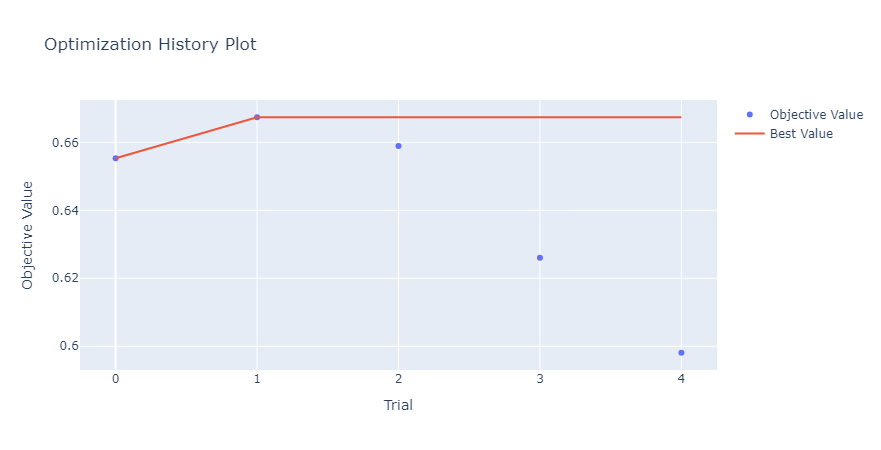

In [1]:
from IPython.display import Image, display
# Le plot ne s'affichait pas
display(Image(filename='newplot.png'))

Bien que l'apprentissage soit vraiment limité en nombre d'étapes, on obtient une idée de la région pour laquelle la valeur d'alpha est la meilleure.

# Submission part

In [ ]:
# Exemple d'utilisation
test_files = [r"test\data_4.npy", r"test\data_5.npy"]  
# Initialiser le dataset
submission_set = EEGDataset_test(test_files)
# Charger les données
submission_loader = DataLoader(submission_set, batch_size=64, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

Loaded signal shape: (5, 6602015)
Reshaped signal shape: (5, 13204, 500)
Loaded signal shape: (5, 4659937)
Reshaped signal shape: (5, 9319, 500)
Final concatenated data shape: (112615, 500)


In [103]:
submission_set.__len__()

112615

In [106]:
def evaluate_xgboost(xgb, model, loader):
    """
    Évalue un XGBoost en utilisant les caractéristiques extraites par un modèle CNN.

    Parameters:
    - xgb: XGBClassifier entraîné.
    - model: Modèle CNN utilisé pour extraire les caractéristiques.
    - loader: DataLoader contenant les données d'évaluation.

    Returns:
    - reshaped_predictions: Prédictions reshaped en (5, Nombre_de_signaux/5).
    """
    model.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    total_signals = 0
    predictions = []
    batch_count = 0

    with torch.no_grad():
        for signals, _ in loader:
            batch_count += 1
            signals = signals.to(device)
            signals = signals.float()
            features = model(signals)  # Extraire les caractéristiques
            preds = xgb.predict(features.cpu().numpy())
            predictions.extend(preds)

            # Comptage
            total_signals += signals.shape[0]

    # Résumé
    print(f"Nombre total de batchs : {batch_count}")
    print(f"Nombre total de signaux explorés : {total_signals}")
    predictions = np.array(predictions)

    # Vérifier que le nombre total de prédictions est divisible par 5
    assert predictions.shape[0] % 5 == 0, "Le nombre total de prédictions n'est pas divisible par 5."

    # Reshaper les prédictions en (5, Nombre_de_signaux/5)
    reshaped_predictions = predictions.reshape(5, -1)
    print(reshaped_predictions.shape, "ici")
    return reshaped_predictions


In [107]:
def format_array_to_target_format(array, record_number):
    assert isinstance(record_number, int)
    assert isinstance(array, np.ndarray)
    assert len(array.shape) == 2
    assert array.shape[0] == 5
    assert set(np.unique(array)) == {0, 1}
    formatted_target = []
    for i in range(array.shape[0]):
        channel_encoding = (i + 1) * 100000
        record_number_encoding = record_number * 1000000
        for j in range(array.shape[1]):
            formatted_target.append(
                {
                    "identifier": record_number_encoding + channel_encoding + j,
                    "target": array[i, j],
                }
            )
    return formatted_target

In [ ]:
# Initialiser le modèle
device = "cuda" if torch.cuda.is_available() else "cpu"
results, results_rf, results_XGB = [], [], []
# Exemple d'utilisation
test_data  = [(4,r"test\data_4.npy"
), (5, r"test\data_5.npy")]
for i, test_file in enumerate(test_data):
    # Initialiser le dataset
    submission_set = EEGDataset_test([test_file[1]])
    # Charger les données
    submission_loader = DataLoader(submission_set, batch_size=64, shuffle=False)
    prediction_XGB = evaluate_xgboost(xgb_, model=model_,loader=submission_loader)
    formatted_preds_XGB = format_array_to_target_format(prediction_XGB,test_file[0])
    results_XGB.extend(formatted_preds_XGB)


In [ ]:
df_xgb = pd.DataFrame(results_XGB)

df_xgb["identifier"] = df_xgb["identifier"].astype(int)
df_xgb["target"] = df_xgb["target"].astype(int)

df_xgb.to_csv("submission_xgb_.csv",sep=",",index = False, na_rep="0")

df_xgb.to_parquet("submission_xgb_.parquet", engine="pyarrow", index=False)
print(df_xgb)

Le modèle n'a pas été autant performant que nous le souhaitions même si nous avons obtenu un score de 0.761. Nous pensons qu'avec plus de ressources et de recul, nous aurions pu mieux dimensionner notre modèle et améliorer ses performances.